In [34]:
!pip install -q clu

In [35]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-05-15 12:59:01--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: 'input.txt.7'

input.txt.7         100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2024-05-15 12:59:01 (26.5 MB/s) - 'input.txt.7' saved [1115394/1115394]



In [36]:
from functools import partial
import jax
import jax.numpy as jnp
from flax import linen as nn
from jax.nn.initializers import lecun_normal, normal
from jax.numpy.linalg import eigh, inv, matrix_power
from jax.scipy.signal import convolve

import torch

from dataclasses import dataclass

from typing import Union

import matplotlib.pyplot as plt
import seaborn

from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers
from tqdm import tqdm

In [37]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [38]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [39]:
# create a mapping from characters to integers
stoi = { ch: i for i,ch in enumerate(chars) }
itos = { i: ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [40]:
data = jnp.array(encode(text), dtype=jnp.int32)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

(1115394,) int32
[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53 59  1 39 56 43  1 39 50 50  1 56 43 57 53 50 60 43 42  1 56 39
 58 46 43 56  1 58 53  1 42 47 43  1 58 46 39 52  1 58 53  1 44 39 51 47
 57 46 12  0  0 13 50 50 10  0 30 43 57 53 50 60 43 42  8  1 56 43 57 53
 50 60 43 42  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 18 47
 56 57 58  6  1 63 53 59  1 49 52 53 61  1 15 39 47 59 57  1 25 39 56 41
 47 59 57  1 47 57  1 41 46 47 43 44  1 43 52 43 51 63  1 58 53  1 58 46
 43  1 54 43 53 54 50 43  8  0  0 13 50 50 10  0 35 43  1 49 52 53 61  5
 58  6  1 61 43  1 49 52 53 61  5 58  8  0  0 18 47 56 57 58  1 15 47 58
 47 64 43 52 10  0 24 43 58  1 59 57  1 49 47 50 50  1 46 47 51  6  1 39
 52 42  1 61 43  5 50 50  1 46 39 

In [41]:
train_test_split = 0.9
n = int(train_test_split*len(data))
train_data = data[:n]
test_data = data[n:]

In [42]:
block_size = 8
train_data[:block_size+1]

Array([18, 47, 56, 57, 58,  1, 15, 47, 58], dtype=int32)

In [43]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is [18] the target: 47
when input is [18 47] the target: 56
when input is [18 47 56] the target: 57
when input is [18 47 56 57] the target: 58
when input is [18 47 56 57 58] the target: 1
when input is [18 47 56 57 58  1] the target: 15
when input is [18 47 56 57 58  1 15] the target: 47
when input is [18 47 56 57 58  1 15 47] the target: 58


In [44]:
batch_size = 256 # how many independent sequences will we process in parallel?
block_size = 64 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 1000
learning_rate = 5e-4
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 128
expans = 2
n_heads = 1
channel_size = n_embd // n_heads
n_layers = 4
dropout = 0.2
conv_k_size = 3
n_latent_dim = 16

rng_key = jax.random.PRNGKey(1564)

dynamic_slice_vmap = jax.vmap(jax.lax.dynamic_slice, in_axes=(None, 0, None))

@jax.jit
def get_batch(random_key, data):
    """Prepares a random batch of training data.

    Args:
      random_key: A random seed for sampling a batch.
      data: The complete training dataset.

    Returns:
      x: Input sequences.
      y: Target sequences (shifted inputs).
    """
    ix = jax.random.randint(
      random_key, shape=(batch_size, 1), minval=0, maxval=len(data) - block_size
    )
    x = dynamic_slice_vmap(data, ix, (block_size,))
    y = dynamic_slice_vmap(data, ix + 1, (block_size,))
    return x, y

xb, yb = get_batch(rng_key, train_data)
train_shape = xb.shape
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

# print('----')

# for b in range(batch_size): # batch dimension
#     for t in range(block_size): # time dimension
#         context = xb[b, :t+1]
#         target = yb[b,t]
#         print(f"when input is {context} the target: {target}")

inputs:
(256, 64)
[[ 6  1 61 ... 53 50 42]
 [21  1 42 ... 44 47 43]
 [58 46 43 ... 43 56 43]
 ...
 [ 6  0 13 ... 46 53 59]
 [45 56 39 ...  1 41 53]
 [ 1 51 43 ... 57 46 53]]
targets:
(256, 64)
[[ 1 61 46 ... 50 42  0]
 [ 1 42 47 ... 47 43 56]
 [46 43  1 ... 56 43  1]
 ...
 [ 0 13 52 ... 53 59 45]
 [56 39 41 ... 41 53 51]
 [51 43 52 ... 46 53 61]]


In [45]:
class RMSNorm(nn.Module):
    d_model: int
    eps: float = 1e-5

    @nn.compact
    def __call__(self, x):
        weight = self.param('weight', nn.initializers.ones, (self.d_model,)) # TODO, maybe use setup will be more clear
        normed = x * jax.lax.rsqrt(np.mean(np.square(x), axis=-1, keepdims=True) + self.eps)
        output = normed * weight
        return output

In [46]:
xb.shape

(256, 64)

In [47]:
class Expan_proj(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=n_embd)(x)
        return x
    
in_proj = nn.Dense(features=n_embd)
params = in_proj.init(rng_key, xb)
in_proj.apply(params, xb).shape

(256, 128)

In [48]:
jax.tree_util.tree_map(lambda x: x.shape, params)

{'params': {'bias': (128,), 'kernel': (64, 128)}}

# Mamba Block
Dense --> Conv1D --> Silu --> SSM --> Silu -->

In [49]:
class MambaBlock(nn.Module):
    
    def setup(self):
        emb_features = n_embd * expans
        self.in_proj1 = nn.Dense(features=emb_features)
        self.in_proj2 = nn.Dense(features=emb_features)
        
        # Adjusted for Flax. Flax does not have nn.Conv1d, so you might need to reshape or use a different approach
        self.conv1d = nn.Conv(features=emb_features,
                              kernel_size=conv_k_size,
                              padding=1,
                              )

        self.A = -1*self.param('A', nn.initializers.ones, (1, n_latent_dim, emb_features, 1))
        self.B = self.param('B', nn.initializers.ones, (1, n_latent_dim, 1, block_size))
        self.C = self.param('C', jax.random.normal, (1, n_latent_dim, 1, block_size))
#         self.D = self.param('D', jax.random.normal, (1, self.args.d_state, self.args.d_model, 1))
        self.delta = self.param('delta', jax.random.normal, (1, 1,emb_features, block_size))
        
        self.out_proj = nn.Dense(n_embd // n_heads)
        
#         self.rms_norm = nn.RMSNorm()
        
    def __call__(self, embeds):

        x = self.in_proj1(embeds)
        x = self.conv1d(x)
        x = jax.nn.silu(x)
        x = x.reshape((x.shape[0],1,x.shape[2],x.shape[1]))
        x = self.ssm(x)[1]
        x = x.reshape((x.shape[0],x.shape[3],x.shape[2]))
        x = x*jax.nn.silu(self.in_proj2(embeds))

        x = self.out_proj(x)
        
#         x = self.rms_norm(x)
        
        return x
    def discretize(self):
        da = self.delta * self.A
        a_ = jnp.exp(da)
        b_ = self.C * self.delta
        return a_, b_

    def ssm(self, x):
        y = []
        h = 0
        a_, b_ = self.discretize()
        for k in range(x.shape[-1]):
            h = a_[..., k] * h + b_[..., k] * x[..., k]
            y.append((self.C[..., k] * h).sum(1, keepdims=True))
        return h, jnp.stack(y, -1)

In [50]:
# model = MambaBlock()
# params = model.init(jax.random.key(0), xb)
# print(model.tabulate(jax.random.key(0), xb,
#                    compute_flops=True, compute_vjp_flops=True))
# xs = model.apply(params, xb)
# xb.shape, xs.shape

In [51]:
class MultiHeadMamba(nn.Module):
    def setup(self):
        self.heads = [MambaBlock() for _ in range(n_heads)]
        self.rms_norm = nn.RMSNorm()
        
    def __call__(self, x):
        out = jnp.concatenate([h(x) for h in self.heads], axis=-1)
        x = self.rms_norm(out)
        return x

In [52]:
class Mamba(nn.Module):
    
    def setup(self):
        self.tok_embeddings = nn.Embed(vocab_size, n_embd)
        self.pos_embeddings = nn.Embed(block_size, n_embd)

        
        self.mamba_layers = [MultiHeadMamba() for _ in range(n_layers)]
        
#         self.preds_out = nn.Dense(vocab_size)
        
    def __call__(self, x):
        x = self.tok_embeddings(x) + self.pos_embeddings(jnp.arange(block_size))
        
        for layer in self.mamba_layers:
            x = layer(x)
            
#         out = self.preds_out(x)
        out = self.tok_embeddings.attend(x)
        return out
    
    @jax.jit
    def generate(self, idx, max_new_tokens, params):
    # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits = self.apply(params, idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            ##probs = tf.keras.activations.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = jax.random.categorical(jax.random.PRNGKey(52), logits) # (B, 1)
            # append sampled index to the running sequence
            idx = jax.numpy.expand_dims(jnp.concatenate([idx[0], idx_next], axis=0), 0) # (B, T+1)
    #         print(idx_next)
    #         print(idx)

        return idx

In [53]:
# test_model = Mamba()
# test_params = test_model.init(jax.random.key(42), xb)
# n_params = sum(p.size for p in jax.tree_util.tree_leaves(test_params))
# print(f"Total number of parameters: {n_params:_}")
# # print(fin_model.tabulate(jax.random.key(42), xb,
# #                    compute_flops=True, compute_vjp_flops=True))
# xf = test_model.apply(test_params, xb)
# xb.shape, xf.shape

In [54]:
# class NanoLM(nn.Module):
#     """NanoLM model."""
#     vocab_size: int = 65
#     num_layers: int = 6
#     num_heads: int = 8
#     head_size: int = 32
#     dropout_rate: float = 0.2
#     embed_size: int = 256
#     block_size: int = 64

#     @nn.compact
#     def __call__(self, x, training: bool):
#         seq_len = x.shape[1]

#         x = nn.Embed(self.vocab_size, self.embed_size)(x) + nn.Embed(
#             self.block_size, self.embed_size
#         )(jnp.arange(seq_len))
#         for _ in range(self.num_layers):
#             x_norm = nn.LayerNorm()(x)
#             x = x + nn.MultiHeadDotProductAttention(
#               num_heads=self.num_heads,
#               qkv_features=self.head_size,
#               out_features=self.head_size * self.num_heads,
#               dropout_rate=self.dropout_rate,
#             )(
#               x_norm,
#               x_norm,
#               mask=jnp.tril(jnp.ones((x.shape[-2], x.shape[-2]))),
#               deterministic=not training,
#             )

#             x = x + nn.Sequential([
#               nn.Dense(4 * self.embed_size),
#               nn.relu,
#               nn.Dropout(self.dropout_rate, deterministic=not training),
#               nn.Dense(self.embed_size),
#             ])(nn.LayerNorm()(x))

#         x = nn.LayerNorm()(x)
#         return nn.Dense(self.vocab_size)(x)

In [55]:
fin_model = Mamba()
fin_params = fin_model.init(jax.random.key(42), xb)
n_params = sum(p.size for p in jax.tree_util.tree_leaves(fin_params))
print(f"Total number of parameters: {n_params:_}")
# print(fin_model.tabulate(jax.random.key(42), xb,
#                    compute_flops=True, compute_vjp_flops=True))
xf = fin_model.apply(fin_params, xb)
xb.shape, xf.shape

Total number of parameters: 1_290_368


((256, 64), (256, 64, 65))

In [56]:
n_embd * expans

256

In [57]:
# token_gen = generate(jnp.zeros((1,1)).astype(jnp.int32), 100, fin_model, fin_params)
# print(token_gen)
# print(decode(token_gen[0].tolist()))

In [58]:
jax.random.categorical(jax.random.PRNGKey(5332), 1000.0*xf[1][-1][:])

Array(9, dtype=int32)

In [59]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

In [60]:
class TrainState(train_state.TrainState):
    metrics: Metrics

def create_train_state(module, rng, learning_rate, train_shape):
    """Creates an initial `TrainState`."""
    params = module.init(rng, jnp.ones(train_shape).astype(jnp.int32))['params'] # initialize parameters by passing a template image
    tx = optax.adamw(learning_rate)
    return TrainState.create(
      apply_fn=module.apply, params=params, tx=tx,
      metrics=Metrics.empty(),
    )

In [61]:
@jax.jit
def train_step(state, inputs, targets):
    """Train for a single step."""
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, inputs)
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=targets).mean()
        return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [62]:
@jax.jit
def compute_metrics(*, state, inputs, targets):
    logits = state.apply_fn({'params': state.params}, inputs)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=targets).mean()
    metric_updates = state.metrics.single_from_model_output(
    logits=logits, labels=targets, loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [63]:
num_epochs = 10
learning_rate = 0.005
init_rng = jax.random.key(0)

In [64]:
state = create_train_state(fin_model, init_rng, learning_rate, train_shape)
del init_rng  # Must not be used anymore.

In [65]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [66]:
SEED = 442
key = jax.random.PRNGKey(SEED)
for step in tqdm(range(max_iters)): # increase number of steps for good results... 
    
      # sample a batch of data
    xb, yb = get_batch(key, train_data)
    state = train_step(state, xb, yb)
    state = compute_metrics(state=state, inputs=xb, targets=yb)
    
    key = (jax.random.split(key)[0])
    
    if step == 0 or (step+1) % 100 == 0: # one training epoch has passed
        for metric,value in state.metrics.compute().items(): # compute metrics
            metrics_history[f'train_{metric}'].append(value) # record metrics
        state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

        # Compute metrics on the test set after each training epoch
        test_state = state
        x_test, y_test = get_batch(key, test_data)
    #     for test_batch in test_ds.as_numpy_iterator():
        test_state = compute_metrics(state=test_state, inputs=x_test, targets=y_test)

        for metric,value in test_state.metrics.compute().items():
            metrics_history[f'test_{metric}'].append(value)

        print(f"train epoch: {(step+1)}, "
              f"loss: {metrics_history['train_loss'][-1]}, "
              f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
        print(f"test epoch: {(step+1) }, "
          f"loss: {metrics_history['test_loss'][-1]}, "
          f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")

  0%|          | 6/5000 [01:22<14:03:36, 10.14s/it] 

train epoch: 1, loss: 4.487237930297852, accuracy: 2.276611328125
test epoch: 1, loss: 4.4962663650512695, accuracy: 2.154541015625


  2%|▏         | 105/5000 [01:37<10:34,  7.72it/s] 

train epoch: 100, loss: 3.1229584217071533, accuracy: 20.052515029907227
test epoch: 100, loss: 2.9124598503112793, accuracy: 24.127197265625


  4%|▍         | 205/5000 [01:51<10:07,  7.89it/s]

train epoch: 200, loss: 2.6120636463165283, accuracy: 31.066953659057617
test epoch: 200, loss: 2.4713211059570312, accuracy: 33.88671875


  6%|▌         | 305/5000 [02:06<09:47,  7.99it/s]

train epoch: 300, loss: 2.294769048690796, accuracy: 38.83673095703125
test epoch: 300, loss: 2.184612274169922, accuracy: 40.97900390625


  8%|▊         | 405/5000 [02:20<09:29,  8.07it/s]

train epoch: 400, loss: 1.9328011274337769, accuracy: 47.1796875
test epoch: 400, loss: 1.7381625175476074, accuracy: 51.715087890625


 10%|█         | 505/5000 [02:34<09:22,  7.98it/s]

train epoch: 500, loss: 1.6541540622711182, accuracy: 54.4644775390625
test epoch: 500, loss: 1.904538869857788, accuracy: 49.62158203125


 12%|█▏        | 605/5000 [02:49<09:12,  7.96it/s]

train epoch: 600, loss: 1.566133975982666, accuracy: 56.71337890625
test epoch: 600, loss: 1.3559980392456055, accuracy: 61.572265625


 14%|█▍        | 705/5000 [03:03<09:03,  7.91it/s]

train epoch: 700, loss: 1.1827380657196045, accuracy: 66.5626220703125
test epoch: 700, loss: 1.1385362148284912, accuracy: 67.767333984375


 16%|█▌        | 805/5000 [03:18<08:49,  7.92it/s]

train epoch: 800, loss: 1.0404917001724243, accuracy: 70.82501220703125
test epoch: 800, loss: 1.0429155826568604, accuracy: 71.27685546875


 18%|█▊        | 905/5000 [03:33<08:34,  7.96it/s]

train epoch: 900, loss: 0.888037383556366, accuracy: 75.595703125
test epoch: 900, loss: 0.8212860822677612, accuracy: 77.252197265625


 20%|██        | 1005/5000 [03:47<08:20,  7.99it/s]

train epoch: 1000, loss: 0.7270143032073975, accuracy: 80.17230224609375
test epoch: 1000, loss: 0.7384037375450134, accuracy: 80.517578125


 22%|██▏       | 1105/5000 [04:01<08:09,  7.95it/s]

train epoch: 1100, loss: 0.6531459093093872, accuracy: 82.1220703125
test epoch: 1100, loss: 0.6019548177719116, accuracy: 83.770751953125


 24%|██▍       | 1205/5000 [04:16<07:56,  7.97it/s]

train epoch: 1200, loss: 0.845710039138794, accuracy: 78.25969696044922
test epoch: 1200, loss: 0.8456124067306519, accuracy: 75.238037109375


 26%|██▌       | 1305/5000 [04:30<07:44,  7.95it/s]

train epoch: 1300, loss: 0.6084107160568237, accuracy: 83.35760498046875
test epoch: 1300, loss: 0.5354840159416199, accuracy: 85.25390625


 28%|██▊       | 1405/5000 [04:45<07:33,  7.93it/s]

train epoch: 1400, loss: 0.5424558520317078, accuracy: 85.94647216796875
test epoch: 1400, loss: 0.5770496129989624, accuracy: 84.039306640625


 30%|███       | 1505/5000 [04:59<07:17,  7.98it/s]

train epoch: 1500, loss: 0.4641176462173462, accuracy: 87.55609130859375
test epoch: 1500, loss: 0.4507192373275757, accuracy: 87.725830078125


 32%|███▏      | 1605/5000 [05:14<07:06,  7.96it/s]

train epoch: 1600, loss: 0.3884256184101105, accuracy: 89.63189697265625
test epoch: 1600, loss: 0.389617919921875, accuracy: 89.0380859375


 34%|███▍      | 1705/5000 [05:28<06:54,  7.95it/s]

train epoch: 1700, loss: 0.4964960515499115, accuracy: 87.80126953125
test epoch: 1700, loss: 0.6474723219871521, accuracy: 85.53466796875


 36%|███▌      | 1805/5000 [05:43<06:42,  7.93it/s]

train epoch: 1800, loss: 0.3947526514530182, accuracy: 89.59033203125
test epoch: 1800, loss: 0.32727760076522827, accuracy: 91.400146484375


 38%|███▊      | 1905/5000 [05:57<06:29,  7.96it/s]

train epoch: 1900, loss: 0.436319500207901, accuracy: 89.7537841796875
test epoch: 1900, loss: 0.6719483137130737, accuracy: 83.65478515625


 40%|████      | 2005/5000 [06:12<06:15,  7.97it/s]

train epoch: 2000, loss: 0.38846755027770996, accuracy: 89.95770263671875
test epoch: 2000, loss: 0.3654743432998657, accuracy: 90.643310546875


 42%|████▏     | 2105/5000 [06:26<06:03,  7.97it/s]

train epoch: 2100, loss: 0.5929926633834839, accuracy: 85.845703125
test epoch: 2100, loss: 0.6957013607025146, accuracy: 80.5908203125


 44%|████▍     | 2205/5000 [06:41<05:50,  7.96it/s]

train epoch: 2200, loss: 0.49273738265037537, accuracy: 86.51251220703125
test epoch: 2200, loss: 0.33608478307724, accuracy: 91.162109375


 46%|████▌     | 2305/5000 [06:55<05:38,  7.97it/s]

train epoch: 2300, loss: 0.2986917197704315, accuracy: 92.137939453125
test epoch: 2300, loss: 0.350852906703949, accuracy: 90.936279296875


 48%|████▊     | 2405/5000 [07:10<05:25,  7.97it/s]

train epoch: 2400, loss: 0.25533735752105713, accuracy: 93.02996063232422
test epoch: 2400, loss: 0.22499775886535645, accuracy: 93.84765625


 50%|█████     | 2505/5000 [07:24<05:12,  7.99it/s]

train epoch: 2500, loss: 0.27204903960227966, accuracy: 92.893310546875
test epoch: 2500, loss: 0.27584144473075867, accuracy: 91.986083984375


 52%|█████▏    | 2605/5000 [07:38<05:00,  7.98it/s]

train epoch: 2600, loss: 0.20699359476566315, accuracy: 94.43621826171875
test epoch: 2600, loss: 0.21065956354141235, accuracy: 94.073486328125


 54%|█████▍    | 2705/5000 [07:53<04:49,  7.94it/s]

train epoch: 2700, loss: 0.24471203982830048, accuracy: 93.72985076904297
test epoch: 2700, loss: 0.2604789137840271, accuracy: 92.315673828125


 56%|█████▌    | 2805/5000 [08:07<04:35,  7.96it/s]

train epoch: 2800, loss: 0.6571692228317261, accuracy: 86.2264404296875
test epoch: 2800, loss: 0.7958774566650391, accuracy: 80.01708984375


 58%|█████▊    | 2905/5000 [08:22<04:22,  7.97it/s]

train epoch: 2900, loss: 0.8927515149116516, accuracy: 79.93157196044922
test epoch: 2900, loss: 1.1287384033203125, accuracy: 73.736572265625


 60%|██████    | 3005/5000 [08:36<04:10,  7.95it/s]

train epoch: 3000, loss: 0.6963581442832947, accuracy: 81.97393798828125
test epoch: 3000, loss: 0.5980269908905029, accuracy: 84.14306640625


 62%|██████▏   | 3105/5000 [08:51<03:58,  7.95it/s]

train epoch: 3100, loss: 0.5435695648193359, accuracy: 85.58349609375
test epoch: 3100, loss: 0.595439612865448, accuracy: 84.2529296875


 64%|██████▍   | 3205/5000 [09:05<03:45,  7.96it/s]

train epoch: 3200, loss: 0.5373743176460266, accuracy: 86.2403564453125
test epoch: 3200, loss: 0.8572472333908081, accuracy: 84.429931640625


 66%|██████▌   | 3305/5000 [09:20<03:33,  7.95it/s]

train epoch: 3300, loss: 0.6373305320739746, accuracy: 84.19384002685547
test epoch: 3300, loss: 0.5408403873443604, accuracy: 85.406494140625


 68%|██████▊   | 3405/5000 [09:34<03:20,  7.94it/s]

train epoch: 3400, loss: 0.4783899188041687, accuracy: 87.08502197265625
test epoch: 3400, loss: 0.46881958842277527, accuracy: 87.261962890625


 70%|███████   | 3505/5000 [09:49<03:07,  7.99it/s]

train epoch: 3500, loss: 0.4978235960006714, accuracy: 87.0235595703125
test epoch: 3500, loss: 0.5127201676368713, accuracy: 85.2294921875


 72%|███████▏  | 3605/5000 [10:03<02:55,  7.97it/s]

train epoch: 3600, loss: 0.5343589782714844, accuracy: 85.9427490234375
test epoch: 3600, loss: 0.443084716796875, accuracy: 87.713623046875


 74%|███████▍  | 3705/5000 [10:18<02:42,  7.95it/s]

train epoch: 3700, loss: 0.43784698843955994, accuracy: 88.3392333984375
test epoch: 3700, loss: 0.47429460287094116, accuracy: 87.957763671875


 76%|███████▌  | 3805/5000 [10:32<02:29,  7.99it/s]

train epoch: 3800, loss: 0.3899817168712616, accuracy: 89.53912353515625
test epoch: 3800, loss: 0.36251604557037354, accuracy: 90.093994140625


 78%|███████▊  | 3905/5000 [10:46<02:17,  7.98it/s]

train epoch: 3900, loss: 0.34625136852264404, accuracy: 90.73858642578125
test epoch: 3900, loss: 0.36305123567581177, accuracy: 90.032958984375


 80%|████████  | 4005/5000 [11:01<02:04,  7.99it/s]

train epoch: 4000, loss: 0.5204805135726929, accuracy: 87.36456298828125
test epoch: 4000, loss: 0.38576310873031616, accuracy: 89.697265625


 82%|████████▏ | 4105/5000 [11:15<01:52,  7.93it/s]

train epoch: 4100, loss: 0.3612898886203766, accuracy: 90.4168701171875
test epoch: 4100, loss: 0.38530945777893066, accuracy: 89.78271484375


 84%|████████▍ | 4205/5000 [11:30<01:40,  7.94it/s]

train epoch: 4200, loss: 0.37332797050476074, accuracy: 90.33043670654297
test epoch: 4200, loss: 0.3783426880836487, accuracy: 90.203857421875


 86%|████████▌ | 4305/5000 [11:44<01:27,  7.98it/s]

train epoch: 4300, loss: 0.39337456226348877, accuracy: 89.91900634765625
test epoch: 4300, loss: 0.3745286762714386, accuracy: 90.22216796875


 88%|████████▊ | 4405/5000 [11:59<01:14,  8.00it/s]

train epoch: 4400, loss: 0.3536165654659271, accuracy: 90.75482177734375
test epoch: 4400, loss: 0.3418373167514801, accuracy: 91.259765625


 90%|█████████ | 4505/5000 [12:13<01:02,  7.96it/s]

train epoch: 4500, loss: 0.537150502204895, accuracy: 87.75524139404297
test epoch: 4500, loss: 0.3991129398345947, accuracy: 89.14794921875


 92%|█████████▏| 4605/5000 [12:28<00:49,  8.01it/s]

train epoch: 4600, loss: 0.34858840703964233, accuracy: 90.89898681640625
test epoch: 4600, loss: 0.3278024196624756, accuracy: 91.363525390625


 94%|█████████▍| 4705/5000 [12:42<00:37,  7.97it/s]

train epoch: 4700, loss: 0.30666235089302063, accuracy: 92.07653045654297
test epoch: 4700, loss: 0.3066074848175049, accuracy: 91.97998046875


 96%|█████████▌| 4805/5000 [12:56<00:24,  7.96it/s]

train epoch: 4800, loss: 0.3120185136795044, accuracy: 91.93920135498047
test epoch: 4800, loss: 0.2957519292831421, accuracy: 92.5048828125


 98%|█████████▊| 4905/5000 [13:11<00:11,  7.94it/s]

train epoch: 4900, loss: 0.293447881937027, accuracy: 92.49211883544922
test epoch: 4900, loss: 0.283037394285202, accuracy: 92.755126953125


100%|██████████| 5000/5000 [13:25<00:00,  6.21it/s]

train epoch: 5000, loss: 0.3175507187843323, accuracy: 92.278076171875
test epoch: 5000, loss: 0.3657097816467285, accuracy: 90.740966796875


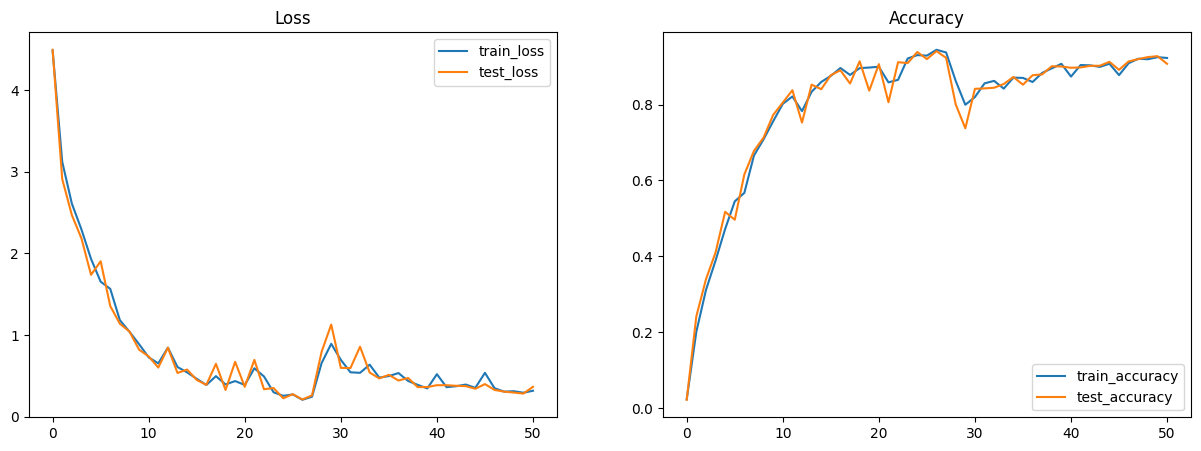

<Figure size 640x480 with 0 Axes>

In [67]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
    ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
    ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [68]:

logits = fin_model.apply(fin_params, xb)
loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=yb).mean()

print(loss)

4.6547575


In [69]:
# def generate_text(idx, max_new_tokens, params):
# # idx is (B, T) array of indices in the current context
#     for i in range(max_new_tokens):
#         # crop idx to the last block_size tokens
#         idx_cond = idx[:, -block_size:]
#         # get the predictions
#         logits = fin_model.apply(params, idx_cond)
#         # focus only on the last time step
#         logits = logits[:, -1, :] # becomes (B, C)

#         if i == 0:
#             rng, rng_subkey = jax.random.split(jax.random.PRNGKey(12))
#         else:
#             rng, rng_subkey = jax.random.split(rng)
            
#         idx_next = jax.random.categorical(rng_subkey, logits, axis=-1, shape=(1, 1)) # (B, 1)

        
#         # append sampled index to the running sequence
#         idx = jnp.concatenate([idx, idx_next], axis=-1) # (B, T+1)

#     return idx

In [70]:
@partial(jax.jit, static_argnames=("self", "length"))
def generate_text(rng, params, length):
    def _scan_generate(carry, _):
        random_key, context = carry
        logits = fin_model.apply(params, context)
        rng, rng_subkey = jax.random.split(random_key)
        new_token = jax.random.categorical(
          rng_subkey, logits[:, -1, :], axis=-1, shape=(1, 1)
        )
        context = jnp.concatenate([context[:, 1:], new_token], axis=1)
        return (rng, context), new_token

    _, new_tokens = jax.lax.scan(
    _scan_generate,
    (rng, jnp.zeros((1, block_size), dtype=jnp.int32)),
    (),
    length=length,
    )
    return new_tokens

/opt/conda/lib/python3.10/site-packages/jax/_src/api_util.py:231: SyntaxWarning: Jitted function has invalid argnames {'self'} in static_argnames. Function does not take these args.This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has invalid argnames {invalid_argnames} "


In [71]:
new_tokenz = 1000
key, subkey = jax.random.split(jax.random.PRNGKey(156))
# key, subkey = jax.random.split(key)
# token_gen = generate_text(jnp.zeros((1,block_size)).astype(jnp.int32), new_tokenz, {'params': state.params})
token_gen = generate_text(key, {'params': state.params}, new_tokenz)[:, 0, 0].tolist()
print(token_gen)
print(decode(token_gen))

[24, 19, 47, 50, 53, 56, 51, 1, 63, 53, 61, 53, 50, 52, 1, 57, 53, 42, 1, 57, 63, 1, 60, 50, 47, 60, 47, 52, 53, 59, 57, 1, 42, 50, 50, 0, 13, 41, 43, 42, 56, 43, 1, 39, 57, 1, 57, 39, 57, 43, 58, 1, 43, 44, 1, 59, 59, 58, 45, 46, 53, 50, 50, 56, 1, 41, 59, 59, 57, 1, 56, 53, 53, 50, 6, 0, 16, 27, 27, 14, 53, 59, 58, 46, 43, 0, 18, 47, 58, 41, 43, 39, 52, 1, 39, 52, 42, 56, 50, 47, 56, 53, 56, 53, 40, 47, 39, 57, 1, 40, 53, 51, 43, 1, 40, 53, 59, 50, 50, 46, 39, 1, 46, 39, 50, 1, 46, 59, 1, 40, 43, 43, 57, 1, 21, 17, 53, 59, 50, 1, 58, 46, 47, 54, 10, 1, 47, 42, 8, 1, 58, 46, 39, 49, 51, 6, 1, 57, 39, 60, 47, 52, 42, 1, 24, 63, 10, 0, 19, 53, 54, 47, 41, 46, 1, 46, 39, 42, 1, 45, 53, 52, 45, 43, 43, 42, 1, 40, 53, 59, 52, 1, 50, 63, 1, 46, 39, 53, 59, 57, 47, 52, 45, 53, 1, 20, 53, 59, 59, 51, 53, 1, 39, 58, 1, 42, 47, 45, 59, 53, 59, 56, 57, 58, 1, 58, 53, 50, 39, 56, 56, 43, 1, 20, 53, 59, 56, 39, 50, 1, 54, 43, 39, 50, 6, 0, 13, 6, 1, 39, 42, 1, 53, 59, 46, 59, 50, 1, 59, 47, 56, 42

In [72]:
print(decode(token_gen))

LGilorm yowoln sod sy vlivinous dll
Acedre as saset ef uutghollr cuus rool,
DOOBouthe
Fitcean andrlirorobias bome boullha hal hu bees IEoul thip: id. thakm, savind Ly:
Gopich had gongeed boun ly haousingo Houumo at diguourst tolarre Houral peal,
A, ad ouhul uird, nga pler th thara thereat bigoad bar yolut yotghe ds, alorey ded mam,

W ouu tinfIA-TEUS:
RRNENUHAIRK, he tham attes thioherron?

Tharol! sous yasd theav?
IRD
ONI:
Goun.
MIEAELAluen sy toutlo cond du, kshire myist toum ris.
M-lo se sm mow.
V tor henons cofiio thes INAco birimerlubt he, a sttr lous:
Hhik. gods thile pong fonesa burowhe hond ar fo ssirhiid eat s sas noug peres Abt' pas:
Woy yaid goukies thtl wou.
Th pot iis yisth ntl yime nust sr mlp yu ond thawe the weamenbinoklls Tout jomerdp mof to iafe.
Fes.Ex'wouur wingud he, dirch hed tololy dalul.
LE
KAches bac
AMCA:
ouuromitopoour foroukt?
Ciser haarlaletharfeluaath thd for ae catret bemes bist hase he couu the d?
WAs s win Tuy xe  d'eucol humee moun irnte borfed tgh'st 

In [73]:
att_model = NanoLM(
    vocab_size=vocab_size,
    num_layers=4,
    num_heads=8,
    head_size=32,
    dropout_rate=0.2,
    embed_size=256,
    block_size=64,
)

var_params = att_model.init(
    key,
    jnp.ones((batch_size, block_size), dtype=jnp.int32),
    training=False,
)

n_params = sum(p.size for p in jax.tree_util.tree_leaves(var_params))

print(f"Total number of parameters: {n_params:_}")

Total number of parameters: 2_289_089


In [74]:
jax.random.categorical(jax.random.PRNGKey(100), jnp.array([10.0,-10.0,-10.0,10.0,-11.0,-11.0,-11.0,-100.0,-1000]))

Array(3, dtype=int32)

In [75]:
logitss = state.apply_fn({'params': state.params}, (43*jnp.zeros((1,1))).astype(jnp.int32))[:,-1,:]

In [76]:
token_gen[:,-32:]

TypeError: list indices must be integers or slices, not tuple

In [ ]:
print("gen text: ",print(decode(token_gen[0].tolist())), "end of text")

In [ ]:
jax.random.randint(jax.random.PRNGKey(52), (1,32), minval, maxval

In [ ]:
import torch
from torch.nn import functional as F
import numpy as np

logitss = state.apply_fn({'params': state.params}, xbb[0].reshape(1,32))[:,-1,:]

probs = F.softmax(torch.from_numpy(np.asarray(logitss)), dim=-1) # (B, C)
# sample from the distribution
idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
idx_next

In [ ]:
state.tx.